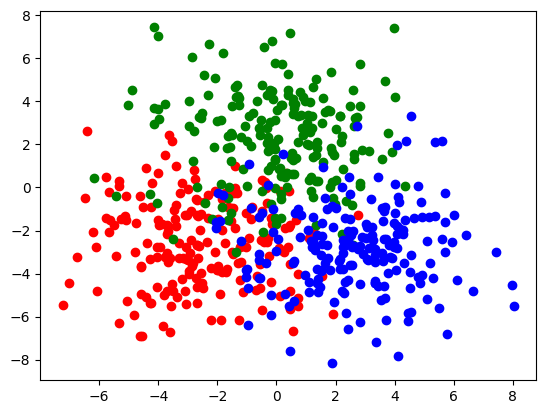

In [145]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import utils.training
import tqdm
import sys
import numpy as np
from importlib import reload
torch.set_default_dtype(torch.float64)

# grid : X1 x X2: [-4,4] x [-4,4]
# C1: mu = (-2.5, -2.5), C2: mu = (0,2.5), C3: mu = (2.5,-2.5)

mu = torch.tensor([[-2.5,-2.5],[0,2.5],[2.5,-2.5]])
sigma = 2

d = mu.shape[1]
ni = 200
C = 3
n = C * ni
train_x = torch.empty((n,d))
train_y = torch.empty((n,))

for idx in range(C):
    train_x[idx*ni:(idx+1)*ni] = torch.randn((ni,d))*sigma + mu[idx]
    train_y[idx*ni:(idx+1)*ni] = idx
train_y.to(dtype=torch.long)

xlim = train_x[:,0].min(),train_x[:,0].max(); ylim = train_x[:,1].min(),train_x[:,1].max()

colors = ['r','g','b']
f,ax = plt.subplots()
for c in range(C):
    xc = train_x[train_y==c]
    ax.scatter(xc[:,0].numpy(),xc[:,1].numpy(),color=colors[c])
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

test_sample = 1000
Mx,My = torch.meshgrid(torch.linspace(xlim[0],xlim[1],100),torch.linspace(ylim[0],ylim[1],test_sample))
test_x = torch.stack([Mx.reshape(-1),My.reshape(-1)],dim=1)

In [146]:
n_test = 500

xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], n_test), np.linspace(ylim[0], ylim[1], n_test)
)

test_grid_points = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).to(
    torch.float64
)

| Epoch [9999/10000] Loss: 0.34415977 Acc@1: 85.500% GradNorm: 0.0039
Gradient norm : 0.003868


(-8.17790826013529, 7.4340072506450685)

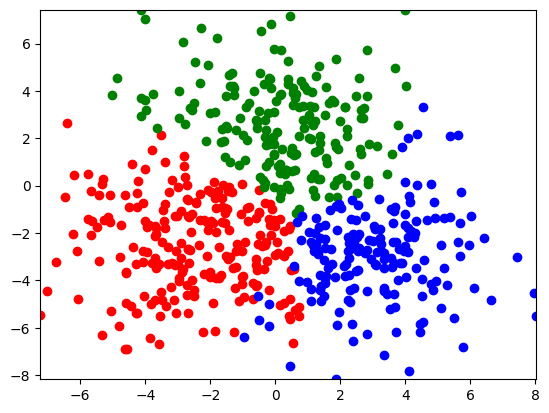

In [148]:
width = 200
epochs = 10000
lr = 0.01
wd = 0

net = torch.nn.Sequential(
            torch.nn.Linear(d, width),
            torch.nn.SiLU(),
            torch.nn.Linear(width, C)
        )
    
ce_loss = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(net.parameters(), 
                        lr = lr, 
                        weight_decay=wd, 
                        momentum=0.9)

for epoch in range(epochs):
    pred = net(train_x)
    loss = ce_loss(pred, train_y.to(dtype=torch.long))

    optim.zero_grad()
    loss.backward()
    optim.step()
    

    acc = (pred.argmax(1) == train_y.to(dtype=torch.long)).type(torch.float).mean().item()

    total_norm = 0
    for p in net.parameters():
        param_norm = p.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)

    sys.stdout.write('\r')
    sys.stdout.write('| Epoch [%3d/%3d] Loss: %.8f Acc@1: %.3f%% GradNorm: %.4f'
            %(epoch, epochs, loss.item(), acc*100, total_norm))
    sys.stdout.flush()

total_norm = 0
for p in net.parameters():
    param_norm = p.grad.data.norm(2)
    total_norm += param_norm.item() ** 2
total_norm = total_norm ** (1. / 2)
print(f'\nGradient norm : {total_norm:.4}')


colors = ['r','g','b']
f,ax = plt.subplots()
for c in range(C):
    xc = train_x[net(train_x).argmax(1) == c].detach()
    ax.scatter(xc[:,0].numpy(),xc[:,1].numpy(),color=colors[c])
ax.set_xlim(xlim)
ax.set_ylim(ylim)



In [149]:
def plot_predictions_classification(
    X_test,
    Y_test,
    y_pred,
    test_grid_points,
    sum_var = False
) -> plt.Figure:
    """Plot the classification results and the associated uncertainty.

    Args:
        X_test: The input features.
        Y_test: The true labels.
        y_pred: The predicted labels.
        test_grid_points: The grid of test points.
        pred_uct: The uncertainty of the predictions.
    """
    fig, axs = plt.subplots(2, 2, figsize=(9, 9))
    cm = plt.cm.get_cmap("plasma")

    grid_size = int(np.sqrt(test_grid_points.shape[0]))
    xx = test_grid_points[:, 0].reshape(grid_size, grid_size)
    yy = test_grid_points[:, 1].reshape(grid_size, grid_size)

    # Create a scatter plot of the input features, colored by the true labels
    axs[0][0].scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm, edgecolors="black")
    axs[0][0].set_title("True Labels")

    # Create a scatter plot of the input features, colored by the predicted labels
    prediction = y_pred.mean(0).argmax(-1)
    axs[0][1].imshow(
        prediction.reshape(grid_size, grid_size),
        alpha=0.8,
        cmap=cm,
        origin="lower",
        extent=[xx.min(), xx.max(), yy.min(), yy.max()],
        interpolation="bicubic",
        aspect="auto",
    )
    axs[0][1].scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm, edgecolors="black")
    axs[0][1].set_title("Predicted Labels")

    # Create a scatter plot of the input features, colored by the uncertainty
    if sum_var:
        unc = y_pred.var(0).sum(-1)
    else:
        unc = y_pred.var(0).max(-1)[0]
    im2 = axs[1][0].imshow(
        y_pred.softmax(-1).var(0).sum(-1).reshape(grid_size, grid_size),
        alpha=0.8,
        cmap=cm,
        origin="lower",
        extent=[xx.min(), xx.max(), yy.min(), yy.max()],
        interpolation="bicubic",
        aspect="auto",
    )
    axs[1][0].scatter(
        X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm, edgecolors="black"
    )
    axs[1][0].set_title("Uncertainty - Variance")
    fig.colorbar(im2, ax=axs[1][0], fraction=0.05, pad=0.008)

    # Create a scatter plot of the input features, colored by the uncertainty
    unc = 1 - y_pred.mean(0).max(-1)[0]
    im3 = axs[1][1].imshow(
        unc.reshape(grid_size, grid_size),
        alpha=0.8,
        cmap=cm,
        origin="lower",
        extent=[xx.min(), xx.max(), yy.min(), yy.max()],
        interpolation="bicubic",
        aspect="auto",
    )
    axs[1][1].scatter(
        X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm, edgecolors="black"
    )
    axs[1][1].set_title("Uncertainty - Confidence")
    fig.colorbar(im3, ax=axs[1][1], fraction=0.05, pad=0.008)

    return fig

In [150]:
class toy_dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i].to(dtype=torch.float64), self.y[i].to(dtype=torch.long)

NUQLS is using device cpu.


100%|██████████| 1000/1000 [00:03<00:00, 274.50it/s, min_loss=0.000944, max_loss=0.0813, min_acc=0.967, max_acc=1, resid_norm=1.08e-6, gpu_mem=0]


Posterior samples computed!


C:\Users\s4531973\AppData\Local\Temp\ipykernel_10728\3056168402.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap("plasma")


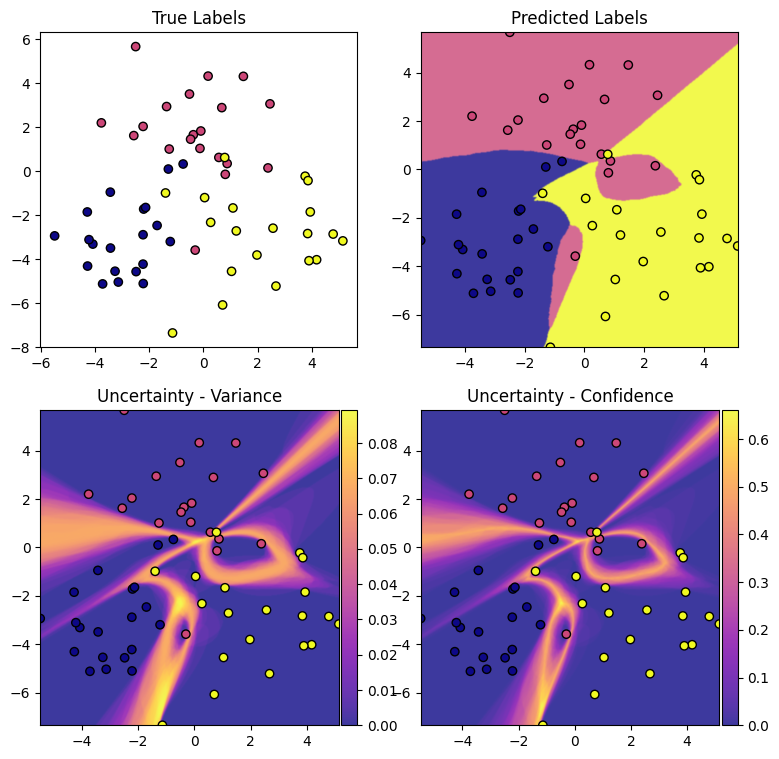

In [139]:
from nuqls.posterior import Nuqls

nuqls_posterior = Nuqls(net, task='classification')
loss,acc = nuqls_posterior.train(train=toy_dataset(train_x,train_y), 
                                    train_bs=n, 
                                    n_output=C,
                                    S=100,
                                    scale=1, 
                                    lr=1e-3, 
                                    epochs=1000, 
                                    mu=0.9,
                                    verbose=True,
                                    extra_verbose=False
                                    )

preds = nuqls_posterior.test(toy_dataset(test_grid_points,torch.ones(test_grid_points.shape)), 200)

scale = 100
preds_new = preds * scale

fig = plot_predictions_classification(X_test=train_x,
                                Y_test=train_y,
                                y_pred=preds_new.softmax(-1),
                                test_grid_points=test_grid_points)

NUQLS is using device cpu.


100%|██████████| 1000/1000 [00:07<00:00, 140.87it/s, min_loss=1.96e-12, max_loss=7.85e-5, min_acc=1, max_acc=1, resid_norm=1.95e-10, gpu_mem=0]  


Posterior samples computed!


C:\Users\s4531973\AppData\Local\Temp\ipykernel_24212\3056168402.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap("plasma")


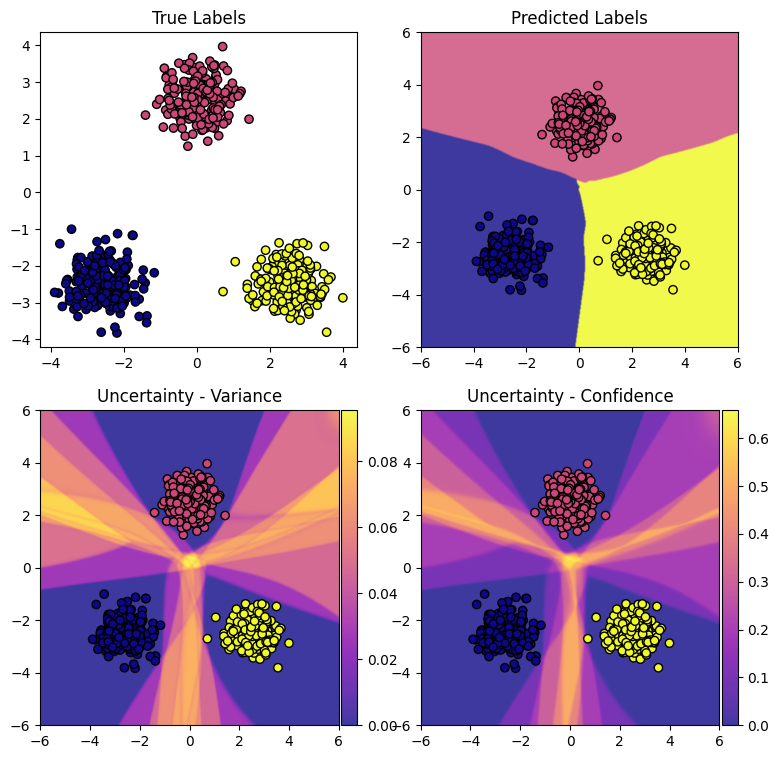

In [19]:
from cuqls.posterior import Cuqls

cuqls_posterior = Cuqls(network=net, task='classification')
loss,acc = cuqls_posterior.train(train=toy_dataset(train_x,train_y), 
                                    batchsize=n, 
                                    S=10,
                                    scale=10, 
                                    lr=1e-1, 
                                    epochs=1000, 
                                    mu=0.9,
                                    verbose=True,
                                    extra_verbose=False
                                    )

preds = cuqls_posterior.test(toy_dataset(test_grid_points,torch.ones(test_grid_points.shape)), 200)

fig1 = plot_predictions_classification(X_test=train_x,
                                Y_test=train_y,
                                y_pred=preds.softmax(-1),
                                test_grid_points=test_grid_points)

100%|██████████| 10/10 [00:45<00:00,  4.53s/it, train nll=7e-9, train mse=1]   
C:\Users\s4531973\AppData\Local\Temp\ipykernel_6916\3056168402.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap("plasma")


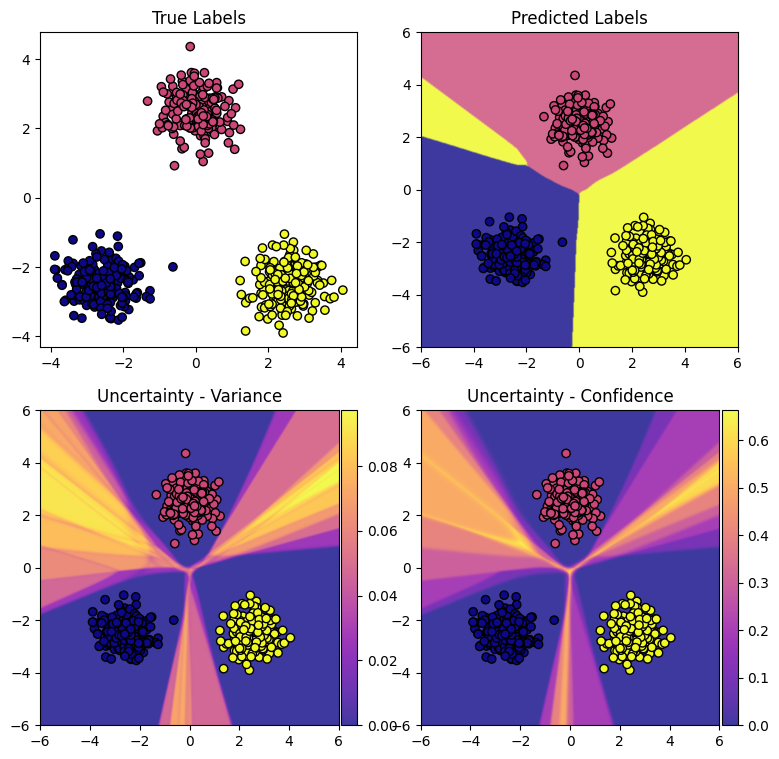

In [70]:
from posteriors.de import DeepEnsemble
from torch.utils.data import DataLoader

train_loader = DataLoader(toy_dataset(train_x,train_y), n)
test_loader = DataLoader(toy_dataset(test_grid_points,torch.ones(test_grid_points.shape)), 200)

de_posterior = DeepEnsemble(network=net, task='classification', M = 10)
train_nll, train_acc = de_posterior.train(loader=train_loader, 
                                        lr=lr, 
                                        wd=wd,
                                        epochs=epochs, 
                                        optim_name='sgd', 
                                        sched_name=None, 
                                        verbose=True,
                                        extra_verbose=False)

predictions = de_posterior.test(test_loader)

fig1 = plot_predictions_classification(X_test=train_x,
                                Y_test=train_y,
                                y_pred=predictions.softmax(-1),
                                test_grid_points=test_grid_points)

In [151]:
from functorch import make_functional, make_functional_with_buffers
from torch.func import functional_call, vmap, jacrev, jvp
import tqdm
fnet, params = make_functional(net)

n_test = 50

xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], n_test), np.linspace(ylim[0], ylim[1], n_test)
)

test_grid_points = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).to(
    torch.float64
)

## Compute jacobian of net, evaluated on training set
def fnet_single(params, x):
    return fnet(params, x.unsqueeze(0)).squeeze(0)

def Jx_ntk(Xs):
    J = vmap(jacrev(fnet_single), (None, 0))(params, Xs)
    J = [j.detach().flatten(2) for j in J]
    J = torch.cat(J,dim=2).detach()
    return J

lam = 0
Jtrain = Jx_ntk(train_x)
print(Jtrain.shape)
NTK_X = Jtrain.flatten(0,1) @ Jtrain.flatten(0,1).T + lam*torch.eye(n*C)
cond = torch.linalg.cond(NTK_X).item()
print(f'Cond(J J^T) = {cond:.1}')

var_ntk = []
for xi in tqdm.tqdm(test_grid_points):
    Jsingle = Jx_ntk(xi.unsqueeze(0))
    KXx = Jtrain.flatten(0,1) @ Jsingle.flatten(0,1).T
    var = Jsingle.flatten(0,1) @ Jsingle.flatten(0,1).T - KXx.T @ torch.linalg.solve(NTK_X,KXx)
    var_ntk.append(var)
var_ntk = torch.stack(var_ntk)

C:\Users\s4531973\AppData\Local\Temp\ipykernel_10728\1497165041.py:4: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(net)


torch.Size([600, 3, 1203])
Cond(J J^T) = 1e+21


 40%|███▉      | 996/2500 [00:19<00:28, 52.02it/s]


KeyboardInterrupt: 

In [160]:
nuqls_posterior.theta_S.shape

torch.Size([903, 100])

In [161]:
def flatten(lst):
    tmp = [i.contiguous().view(-1, 1) for i in lst]
    return torch.cat(tmp).view(-1)

In [162]:
nuqls_posterior.theta_S

tensor([[-0.1133, -1.5116,  0.3086,  ..., -0.9747,  1.8444, -0.0531],
        [ 1.3311,  1.7303,  0.7136,  ...,  1.7611,  1.1277, -0.1353],
        [ 0.6819,  0.4051,  0.0298,  ...,  0.0533, -0.5078, -0.4147],
        ...,
        [-2.4495, -0.9320,  0.2794,  ..., -0.7266,  1.7917,  1.7279],
        [ 1.1070, -0.5948, -1.3520,  ...,  0.4455,  0.2345, -1.0329],
        [-0.3403, -0.1199, -0.0814,  ..., -1.3695,  0.7396,  0.4263]])

In [163]:
theta = (nuqls_posterior.theta_S-flatten(params).reshape(-1,1))
print(Jtrain @ theta)

tensor([[[-4.0736e+00,  6.9141e+00, -3.3750e+00,  ..., -2.5855e+01,
           1.2578e+01, -4.0543e+00],
         [-2.9095e+00, -1.3134e+01,  1.8234e+01,  ...,  1.0816e+01,
           3.5796e+00, -4.0110e+00],
         [-6.4966e+00, -1.2351e+01, -2.6694e-02,  ...,  4.7640e+00,
           1.1500e+01, -5.7207e+00]],

        [[-1.2747e+01,  4.5578e+00, -6.6362e+00,  ..., -3.1399e+01,
           6.6382e+00, -9.7727e+00],
         [-3.2968e-01, -1.5398e+01,  1.7225e+01,  ...,  1.0473e+01,
           5.5842e+00,  1.1886e+00],
         [-6.5982e+00, -1.5732e+01,  7.1546e+00,  ...,  3.5368e+00,
           1.7639e+01, -9.5025e+00]],

        [[-8.3478e+00,  6.2907e+00, -6.1171e+00,  ..., -3.2425e+01,
           1.1783e+01, -8.1615e+00],
         [-2.5977e+00, -1.6412e+01,  2.0777e+01,  ...,  1.1538e+01,
           4.9128e+00, -1.2366e+00],
         [-8.1300e+00, -1.6043e+01,  3.4214e+00,  ...,  4.4655e+00,
           1.5685e+01, -8.0835e+00]],

        ...,

        [[-2.7475e+01,  2.2248e+00,

In [155]:
torch.diagonal(var_ntk, dim1 = - 2, dim2 = -1)

tensor([[ 8.7495e-05,  1.2288e-04,  4.4281e-05],
        [ 7.1117e-05,  9.6034e-05,  4.4608e-05],
        [ 5.5845e-05,  7.1872e-05,  4.0713e-05],
        ...,
        [ 1.7354e-02,  2.4712e-03,  1.0561e-02],
        [ 2.1197e-02, -1.7790e-03,  1.3689e-02],
        [ 2.6196e-02, -5.1935e-03,  1.8701e-02]])

In [156]:
preds_new.var(0)

tensor([[1783.6735, 1799.2342,  946.8406],
        [1704.5820, 1728.0468,  915.0716],
        [1628.3598, 1659.7871,  884.4334],
        ...,
        [1230.4488, 1229.2408, 1521.7855],
        [1277.0404, 1284.5393, 1592.6378],
        [1325.7641, 1343.3414, 1666.8502]])

In [144]:
from nuqls.posterior import Nuqls

nuqls_posterior = Nuqls(net, task='classification')

scale_range = np.linspace(1,2,10)
for scale in scale_range:
    loss,acc = nuqls_posterior.train(train=toy_dataset(train_x,train_y), 
                                        train_bs=n, 
                                        n_output=C,
                                        S=100,
                                        scale=scale, 
                                        lr=5e-1, 
                                        epochs=1000, 
                                        mu=0.9,
                                        threshold=0.00036266,
                                        verbose=True,
                                        extra_verbose=False
                                        )

    preds = nuqls_posterior.test(toy_dataset(test_grid_points,torch.ones(test_grid_points.shape)), 200)
    print(f'scale: {scale}, scale^2: {scale**2}')
    if scale == 1:
        scale_var_orig = preds.var(0).mean(0)[0]
        scale_var_orig_probit = preds.softmax(-1).var(0).mean(0)[0]
    print(f'logit var: {preds.var(0).mean(0)[0]:.3f}, ratio: {(preds.var(0).mean(0)[0] / scale_var_orig):.3f}')
    print(f'probit var: {preds.softmax(-1).var(0).mean(0)[0]:.3f}, ratio: {(preds.softmax(-1).var(0).mean(0)[0] / scale_var_orig_probit):.3f}')


c:\Users\s4531973\Documents\PhD\Code\nuqls\.venv\Lib\site-packages\nuqls\classification.py:40: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(self.network)


NUQLS is using device cpu.


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 257.36it/s, min_loss=0.000326, max_loss=0.000484, min_acc=1, max_acc=1, resid_norm=8.31e-9, gpu_mem=0] 


Posterior samples computed!
scale: 1.0, scale^2: 1.0
logit var: 18279.000, ratio: 1.000
probit var: 0.018, ratio: 1.000


100%|██████████| 1000/1000 [00:03<00:00, 255.19it/s, min_loss=0.000322, max_loss=0.000549, min_acc=1, max_acc=1, resid_norm=1.29e-8, gpu_mem=0] 


Posterior samples computed!
scale: 1.1111111111111112, scale^2: 1.234567901234568
logit var: 26451.178, ratio: 1.447
probit var: 0.018, ratio: 0.949


100%|██████████| 1000/1000 [00:03<00:00, 256.22it/s, min_loss=0.000323, max_loss=0.000569, min_acc=1, max_acc=1, resid_norm=1.2e-8, gpu_mem=0]  


Posterior samples computed!
scale: 1.2222222222222223, scale^2: 1.4938271604938274
logit var: 28009.241, ratio: 1.532
probit var: 0.019, ratio: 1.046


100%|██████████| 1000/1000 [00:03<00:00, 257.29it/s, min_loss=0.000322, max_loss=0.000644, min_acc=1, max_acc=1, resid_norm=1.21e-8, gpu_mem=0] 


Posterior samples computed!
scale: 1.3333333333333333, scale^2: 1.7777777777777777
logit var: 32624.707, ratio: 1.785
probit var: 0.018, ratio: 0.985


100%|██████████| 1000/1000 [00:03<00:00, 251.73it/s, min_loss=0.000338, max_loss=0.000483, min_acc=1, max_acc=1, resid_norm=9.27e-9, gpu_mem=0] 


Posterior samples computed!
scale: 1.4444444444444444, scale^2: 2.0864197530864197
logit var: 31398.930, ratio: 1.718
probit var: 0.019, ratio: 1.009


 71%|███████   | 706/1000 [00:02<00:01, 255.03it/s, min_loss=0.000319, max_loss=0.000587, min_acc=1, max_acc=1, resid_norm=1.77e-8, gpu_mem=0]  


KeyboardInterrupt: 

In [85]:
from cuqls.posterior import Cuqls

cuqls_posterior = Cuqls(net, task='classification')

scale_range = np.linspace(1,2,11)
for scale in scale_range:
    loss,acc = cuqls_posterior.train(train=toy_dataset(train_x,train_y), 
                                        batchsize=n, 
                                        S=100,
                                        scale=scale, 
                                        lr=1e-1, 
                                        epochs=500, 
                                        mu=0.9,
                                        verbose=True,
                                        extra_verbose=False,
                                        threshold=0
                                        )

    preds = cuqls_posterior.test(toy_dataset(test_grid_points,torch.ones(test_grid_points.shape)), 200)
    print(f'scale: {scale}, scale^2: {scale**2}')
    if scale == 1:
        scale_var_orig = preds.var(0).mean(0)[0]
        scale_var_orig_probit = preds.softmax(-1).var(0).mean(0)[0]
    print(f'logit var: {preds.var(0).mean(0)[0]:.3f}, ratio: {(preds.var(0).mean(0)[0] / scale_var_orig):.3f}')
    print(f'probit var: {preds.softmax(-1).var(0).mean(0)[0]:.3f}, ratio: {(preds.softmax(-1).var(0).mean(0)[0] / scale_var_orig_probit):.3f}')


NUQLS is using device cpu.


100%|██████████| 500/500 [00:05<00:00, 85.93it/s, min_loss=0.314, max_loss=0.325, min_acc=0.853, max_acc=0.87, resid_norm=6.82e-8, gpu_mem=0] 


Posterior samples computed!
scale: 1.0, scale^2: 1.0
logit var: 27.948, ratio: 1.000
probit var: 0.000, ratio: 1.000


100%|██████████| 500/500 [00:06<00:00, 82.35it/s, min_loss=0.315, max_loss=0.325, min_acc=0.857, max_acc=0.867, resid_norm=7.38e-8, gpu_mem=0]


Posterior samples computed!
scale: 1.1, scale^2: 1.2100000000000002
logit var: 39.252, ratio: 1.404
probit var: 0.001, ratio: 1.072


100%|██████████| 500/500 [00:06<00:00, 82.16it/s, min_loss=0.316, max_loss=0.327, min_acc=0.855, max_acc=0.867, resid_norm=8.13e-8, gpu_mem=0]


Posterior samples computed!
scale: 1.2, scale^2: 1.44
logit var: 39.469, ratio: 1.412
probit var: 0.001, ratio: 1.294


 69%|██████▉   | 344/500 [00:04<00:01, 81.96it/s, min_loss=0.316, max_loss=0.335, min_acc=0.847, max_acc=0.87, resid_norm=1.35e-7, gpu_mem=0] 


KeyboardInterrupt: 

# Extra Problem

In [12]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import utils.training
import tqdm
import sys
import numpy as np
from importlib import reload
torch.set_default_dtype(torch.float64)

class toy_dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
class variable_mlp(torch.nn.Module):
    def __init__(self,layer_width,nonlin,num_output):
        super().__init__()
        self.layer_width = layer_width
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_width[i],layer_width[i+1], bias=True) for i in range(len(self.layer_width)-1)])
        self.lin_out = torch.nn.Linear(self.layer_width[-1],num_output, bias=True)
        if nonlin=='tanh':
            self.act = torch.nn.Tanh()
        elif nonlin=='relu':
            self.act = torch.nn.ReLU()

        for lin in self.linear_layers:
            torch.nn.init.normal_(lin.weight, 0, 1)
        torch.nn.init.normal_(self.lin_out.weight, 0, 1)

    # Return full output of nn
    def forward(self,x):
        for i, lin in enumerate(self.linear_layers):
            x = self.act(lin(x)) / (self.layer_width[i]**0.5)
        return self.lin_out(x)
    
samples = 2
n = 100
d = 2
c = 3
results_dict = {}

# single-layer, width=120, tanh
print(f'single-layer, width=120, tanh')
layer_widths = [d,100]

X = torch.randn((n,d))
Y = torch.randint(low=0, high=3, size=(n,))

X_test = torch.randn((n,d))

net = variable_mlp(layer_width=layer_widths,nonlin='tanh',num_output=c)
num_weights = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'p: {num_weights}')

optimizer = torch.optim.SGD(net.parameters(),lr=2e0,momentum=0.9,weight_decay=0)
loss_fn = torch.nn.CrossEntropyLoss()
for i in range(20000):
    optimizer.zero_grad()
    pred = net(X)
    loss = loss_fn(pred,Y)
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f'nn loss : {loss.item():.4}')

total_norm = 0
pred = net(X)
loss = loss_fn(pred,Y)
print(f'nn loss : {loss.item():.4}')
loss.backward()
for p in net.parameters():
    param_norm = p.grad.data.norm(2)
    total_norm += param_norm.item() ** 2
total_norm = total_norm ** (1. / 2)
print(f'Gradient norm : {total_norm:.4}')

single-layer, width=120, tanh
p: 603
nn loss : 3.066
nn loss : 0.3773
nn loss : 0.0386
nn loss : 0.02708
nn loss : 0.02142
nn loss : 0.01817
nn loss : 0.01587
nn loss : 0.01409
nn loss : 0.01264
nn loss : 0.01142
nn loss : 0.01038
nn loss : 0.00947
nn loss : 0.008671
nn loss : 0.00796
nn loss : 0.007324
nn loss : 0.006753
nn loss : 0.006239
nn loss : 0.005775
nn loss : 0.005357
nn loss : 0.00498
nn loss : 0.004639
nn loss : 0.00433
nn loss : 0.00405
nn loss : 0.003796
nn loss : 0.003566
nn loss : 0.003356
nn loss : 0.003164
nn loss : 0.00299
nn loss : 0.002829
nn loss : 0.002683
nn loss : 0.002548
nn loss : 0.002424
nn loss : 0.002309
nn loss : 0.002204
nn loss : 0.002106
nn loss : 0.002015
nn loss : 0.00193
nn loss : 0.001852
nn loss : 0.001778
nn loss : 0.00171
nn loss : 0.001646
nn loss : 0.001586
nn loss : 0.00153
nn loss : 0.001477
nn loss : 0.001427
nn loss : 0.00138
nn loss : 0.001336
nn loss : 0.001295
nn loss : 0.001255
nn loss : 0.001218
nn loss : 0.001182
nn loss : 0.001149


In [3]:
from functorch import make_functional, make_functional_with_buffers
from torch.func import functional_call, vmap, jacrev, jvp
import tqdm

# Compute NTKGP
fnet, params = make_functional(net)

## Compute jacobian of net, evaluated on training set
def fnet_single(params, x):
    return fnet(params, x.unsqueeze(0)).squeeze(0)

def Jx(Xs):
    J = vmap(jacrev(fnet_single), (None, 0))(params, Xs)
    J = [j.detach().flatten(2) for j in J]
    J = torch.cat(J,dim=2).detach()
    return J

lam = 0
scale = 1
Jtrain = Jx(X).flatten(0,1)
NTKtrain = Jtrain @ Jtrain.T
print(f'Condition number: {torch.linalg.cond(NTKtrain)}')

var_ntk = []
for xi in tqdm.tqdm(X_test):
    Jsingle = Jx(xi.unsqueeze(0)).flatten(0,1)
    KXx = Jtrain @ Jsingle.T
    var = Jsingle @ Jsingle.T - KXx.T @ torch.linalg.solve(NTKtrain,KXx)
    var_ntk.append(var)
var_ntk = torch.stack(var_ntk)

C:\Users\s4531973\AppData\Local\Temp\ipykernel_8064\3895199003.py:6: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(net)


Condition number: inf


  0%|          | 0/100 [00:00<?, ?it/s]


_LinAlgError: torch.linalg.solve: The solver failed because the input matrix is singular.

In [108]:
Jsingle.shape

torch.Size([3, 903])

In [106]:
KXx.shape

torch.Size([300, 3])

In [105]:
var_ntk.shape

torch.Size([100, 3, 3])

In [132]:
train_data = toy_dataset(X,Y)
test_data = toy_dataset(X_test,Y)

nuqls_posterior = Nuqls(net, task='classification')

loss,acc = nuqls_posterior.train(train=train_data, 
                                    train_bs=n, 
                                    n_output=c,
                                    S=10,
                                    scale=0.1, 
                                    lr=1e-2, 
                                    epochs=1, 
                                    mu=0,
                                    threshold=3.621,
                                    verbose=True,
                                    extra_verbose=False
                                    )

preds = nuqls_posterior.test(test_data, 200)

print((Jtrain @ nuqls_posterior.theta_S).var(1).mean(0))

NUQLS is using device cpu.


100%|██████████| 1/1 [00:00<00:00, 322.71it/s, min_loss=3.36, max_loss=3.89, min_acc=0.32, max_acc=0.36, resid_norm=0.00324, gpu_mem=0]

Posterior samples computed!
tensor(0.4090)


In [131]:
Jtrain @ nuqls_posterior.theta_S

tensor([[ 5.0147,  5.0111,  5.1194,  ...,  5.0512,  5.0998,  5.0860],
        [ 5.5044,  5.5532,  5.5863,  ...,  5.6736,  5.5827,  5.4445],
        [-5.2569, -5.6434, -5.5308,  ..., -5.5061, -5.5267, -5.4068],
        ...,
        [ 6.9351,  6.7591,  6.8990,  ...,  6.8777,  6.9452,  6.9553],
        [ 5.3370,  5.3964,  5.3164,  ...,  5.3662,  5.3291,  5.2902],
        [-4.0857, -4.4010, -4.2525,  ..., -4.2379, -4.2612, -4.1664]])

In [99]:
def flatten(lst):
    tmp = [i.contiguous().view(-1, 1) for i in lst]
    return torch.cat(tmp).view(-1)

theta_map = flatten(params)

In [100]:
(Jtrain @ nuqls_posterior.theta_S).mean(1)

tensor([-7.3249e+00, -2.2435e+00, -5.2243e+00,  1.0817e+00,  4.5786e+00,
        -7.9447e+00,  4.1098e+00,  1.8849e+00, -3.5002e+00,  4.2488e-01,
        -5.7167e-01, -5.4016e+00,  3.6203e+00,  2.7406e+00, -7.6732e+00,
        -2.4343e-01,  1.1968e+00, -5.6874e+00,  4.0490e+00,  6.4695e+00,
        -5.8111e+00, -2.0425e+00,  5.9100e-01, -1.2461e+01,  4.6792e+00,
        -5.2258e-01, -1.8983e+00, -1.1941e+00,  3.4176e+00, -5.1572e+00,
         2.2373e+00,  4.3586e+00, -5.9556e+00,  3.9427e+00,  9.8479e-01,
        -2.3610e+00,  1.7430e+00,  2.2763e-01, -9.6034e+00,  3.1670e+00,
         6.6013e+00, -5.3191e+00, -2.4213e+00, -1.6692e+00, -1.3054e+01,
         6.3655e-01,  3.5568e+00, -7.2735e+00,  2.7232e-01, -3.5666e+00,
        -9.5434e+00,  2.3738e+00,  5.7103e-01, -5.0378e+00,  1.6259e+00,
         6.3873e+00,  6.6449e-01,  1.6877e+00,  2.2558e+00,  2.1386e-01,
         5.0719e-02, -3.5492e+00, -1.1749e+01,  1.4419e+00, -1.2162e+00,
        -9.5888e+00,  3.9614e+00, -3.6738e-01, -5.9

In [101]:
Jtrain @ theta_map

tensor([-8.2443e+00, -7.0017e+00,  2.0887e+00,  4.9798e+00,  1.4162e+00,
        -6.3281e+00,  9.4565e-01, -2.0256e+00,  5.1683e+00, -4.1196e+00,
         1.2978e+00, -3.7866e+00,  6.8686e-01, -6.2479e-01, -5.3832e-01,
        -1.9323e+00, -4.9870e+00,  3.8623e+00, -1.0211e+00,  3.7741e+00,
        -1.0042e+00, -4.2210e+00, -6.3036e-01, -6.8113e+00,  2.0673e+00,
        -3.7335e+00,  9.2147e+00, -2.6250e+00, -2.3055e-01, -7.4043e-01,
         5.6086e+00, -4.3040e+00,  2.3723e+00,  1.0194e+00, -1.4668e+00,
         5.2037e+00, -4.2815e+00, -2.0945e+00,  7.6898e-01, -2.2703e-01,
         6.6588e+00, -2.0417e+00, -3.9376e+00, -6.7622e+00, -4.0480e+00,
        -8.2367e-01,  1.9386e+00, -6.5239e+00, -2.2970e+00, -7.8041e+00,
         2.8973e-01,  1.7756e+00, -3.0892e+00,  3.9636e+00, -6.2637e-01,
         7.1836e+00, -6.4162e-01, -8.6096e-01, -5.2998e+00,  9.0920e+00,
        -3.7456e+00, -6.7779e+00, -1.2101e+00, -4.5141e+00, -2.2855e+00,
        -2.2783e+00,  3.9251e+00, -4.6053e+00,  4.1

In [109]:
torch.diagonal(var_ntk, dim1 = - 2, dim2 = -1) * 0.1

tensor([[0.6136, 0.5098, 0.8865],
        [0.3321, 0.3963, 0.4573],
        [0.1826, 0.1674, 0.1952],
        [0.3077, 0.2553, 0.3298],
        [0.1735, 0.1546, 0.2286],
        [0.4786, 0.5233, 0.7465],
        [0.5143, 0.4165, 0.4605],
        [0.2910, 0.2122, 0.2968],
        [0.3551, 0.4032, 0.5370],
        [0.1161, 0.1055, 0.1460],
        [0.5791, 0.6940, 0.7099],
        [0.4283, 0.5544, 0.6223],
        [0.0866, 0.0945, 0.1088],
        [0.2933, 0.2364, 0.3112],
        [0.0496, 0.0537, 0.0584],
        [0.1907, 0.1955, 0.2672],
        [0.8058, 0.6736, 1.0135],
        [0.1074, 0.0981, 0.1925],
        [0.2671, 0.1993, 0.2466],
        [0.1845, 0.2307, 0.2114],
        [0.3243, 0.4614, 0.4452],
        [0.1624, 0.1939, 0.3474],
        [0.3672, 0.4361, 0.4112],
        [0.2742, 0.3185, 0.5372],
        [0.3531, 0.4025, 0.4386],
        [0.2278, 0.2697, 0.2470],
        [0.2724, 0.2813, 0.3781],
        [0.1936, 0.2020, 0.2221],
        [0.5067, 0.5647, 0.6110],
        [0.292

In [103]:
preds.var(0)

tensor([[0.1755, 0.2423, 0.5686],
        [0.1504, 0.2954, 0.3228],
        [0.0642, 0.1160, 0.1967],
        [0.1852, 0.1288, 0.1610],
        [0.1240, 0.0681, 0.1214],
        [0.0978, 0.1350, 0.2760],
        [0.1971, 0.1862, 0.2523],
        [0.1233, 0.0577, 0.1154],
        [0.4032, 0.2794, 0.6117],
        [0.1736, 0.2056, 0.1417],
        [0.0973, 0.1728, 0.2718],
        [0.1628, 0.3195, 0.1973],
        [0.0812, 0.1737, 0.2559],
        [0.1467, 0.2043, 0.1343],
        [0.0985, 0.1416, 0.1510],
        [0.3122, 0.2986, 0.2342],
        [0.1792, 0.0474, 0.1052],
        [0.1461, 0.1149, 0.1905],
        [0.2844, 0.1825, 0.1768],
        [0.1069, 0.1887, 0.2347],
        [0.2308, 0.3316, 0.1586],
        [0.2411, 0.1700, 0.2948],
        [0.2395, 0.3926, 0.3315],
        [0.1299, 0.1106, 0.2166],
        [0.2038, 0.0986, 0.1159],
        [0.3023, 0.2300, 0.2614],
        [0.2147, 0.1534, 0.2149],
        [0.0611, 0.1283, 0.1413],
        [0.4311, 0.5890, 0.2762],
        [0.121

In [133]:
from nuqls.posterior import Nuqls

train_data = toy_dataset(X,Y)
test_data = toy_dataset(X_test,Y)

nuqls_posterior = Nuqls(net, task='classification')

scale_range = np.linspace(1,2,10)
for scale in scale_range:
    loss,acc = nuqls_posterior.train(train=train_data, 
                                        train_bs=n, 
                                        n_output=c,
                                        S=100,
                                        scale=scale, 
                                        lr=5e-1, 
                                        epochs=1, 
                                        mu=0.9,
                                        threshold=0.0007531,
                                        verbose=True,
                                        extra_verbose=False
                                        )

    preds = nuqls_posterior.test(test_data, 200)
    print(f'scale: {scale}, scale^2: {scale**2}')
    if scale == 1:
        scale_var_orig = preds.var(0).mean(0)[0]
        scale_var_orig_probit = preds.softmax(-1).var(0).mean(0)[0]
    print(f'logit var: {preds.var(0).mean(0)[0]:.3f}, ratio: {(preds.var(0).mean(0)[0] / scale_var_orig):.3f}')
    print(f'probit var: {preds.softmax(-1).var(0).mean(0)[0]:.3f}, ratio: {(preds.softmax(-1).var(0).mean(0)[0] / scale_var_orig_probit):.3f}')


NUQLS is using device cpu.


100%|██████████| 1/1 [00:00<?, ?it/s, min_loss=2.66, max_loss=11, min_acc=0.16, max_acc=0.5, resid_norm=0.0029, gpu_mem=0]


Posterior samples computed!
scale: 1.0, scale^2: 1.0
logit var: 33.203, ratio: 1.000
probit var: 0.161, ratio: 1.000


100%|██████████| 1/1 [00:00<00:00, 291.33it/s, min_loss=4.25, max_loss=11.3, min_acc=0.18, max_acc=0.5, resid_norm=0.00288, gpu_mem=0]


Posterior samples computed!
scale: 1.1111111111111112, scale^2: 1.234567901234568
logit var: 40.243, ratio: 1.212
probit var: 0.169, ratio: 1.050


100%|██████████| 1/1 [00:00<00:00, 297.36it/s, min_loss=3.36, max_loss=12.3, min_acc=0.19, max_acc=0.51, resid_norm=0.00289, gpu_mem=0]


Posterior samples computed!
scale: 1.2222222222222223, scale^2: 1.4938271604938274
logit var: 47.743, ratio: 1.438
probit var: 0.175, ratio: 1.089


100%|██████████| 1/1 [00:00<?, ?it/s, min_loss=3.67, max_loss=13.5, min_acc=0.11, max_acc=0.49, resid_norm=0.00298, gpu_mem=0]


Posterior samples computed!
scale: 1.3333333333333333, scale^2: 1.7777777777777777
logit var: 53.500, ratio: 1.611
probit var: 0.178, ratio: 1.108


100%|██████████| 1/1 [00:00<00:00, 344.42it/s, min_loss=4.08, max_loss=14.1, min_acc=0.19, max_acc=0.49, resid_norm=0.003, gpu_mem=0]


Posterior samples computed!
scale: 1.4444444444444444, scale^2: 2.0864197530864197
logit var: 69.820, ratio: 2.103
probit var: 0.176, ratio: 1.095


100%|██████████| 1/1 [00:00<00:00, 67.80it/s, min_loss=5.04, max_loss=13.2, min_acc=0.19, max_acc=0.46, resid_norm=0.00279, gpu_mem=0]


Posterior samples computed!
scale: 1.5555555555555556, scale^2: 2.419753086419753
logit var: 79.553, ratio: 2.396
probit var: 0.193, ratio: 1.199


100%|██████████| 1/1 [00:00<?, ?it/s, min_loss=5.49, max_loss=16.6, min_acc=0.19, max_acc=0.51, resid_norm=0.00296, gpu_mem=0]


Posterior samples computed!
scale: 1.6666666666666665, scale^2: 2.7777777777777772
logit var: 98.408, ratio: 2.964
probit var: 0.189, ratio: 1.173


100%|██████████| 1/1 [00:00<00:00, 1041.03it/s, min_loss=5.56, max_loss=17.2, min_acc=0.14, max_acc=0.49, resid_norm=0.00297, gpu_mem=0]


Posterior samples computed!
scale: 1.7777777777777777, scale^2: 3.1604938271604937
logit var: 115.595, ratio: 3.481
probit var: 0.194, ratio: 1.208


100%|██████████| 1/1 [00:00<00:00, 249.66it/s, min_loss=5.7, max_loss=17.1, min_acc=0.12, max_acc=0.5, resid_norm=0.00296, gpu_mem=0]


Posterior samples computed!
scale: 1.8888888888888888, scale^2: 3.567901234567901
logit var: 123.322, ratio: 3.714
probit var: 0.196, ratio: 1.216


100%|██████████| 1/1 [00:00<00:00, 64.79it/s, min_loss=5.04, max_loss=19.2, min_acc=0.21, max_acc=0.56, resid_norm=0.00282, gpu_mem=0]

Posterior samples computed!
scale: 2.0, scale^2: 4.0
logit var: 149.209, ratio: 4.494
probit var: 0.203, ratio: 1.261
